# GreenDoc.AI Codebase

This is our **model code and comparison** for GreenDoc.AI . The **EDA** can be found in a seperate Notebook.

At GreenDoc.AI our goal is to improve the process of tomato farming by taking images of tomato plants, identifying leafes via an object detection model (that is out of scope of this notebook) and classifying these leaves to see if they are **healthy** or have a specific desease:

**Powdery Mildew                           
Late Blight                              
Septoria Leaf Spot                       
Tomato Yellow Leaf Curl Virus                                             
Early Blight                             
Target Spot                              
Leaf Mold                                
Tomato Mosaic Virus                      
Bacterial Spot                           
Spider Mites Two-spotted Spider Mite**     


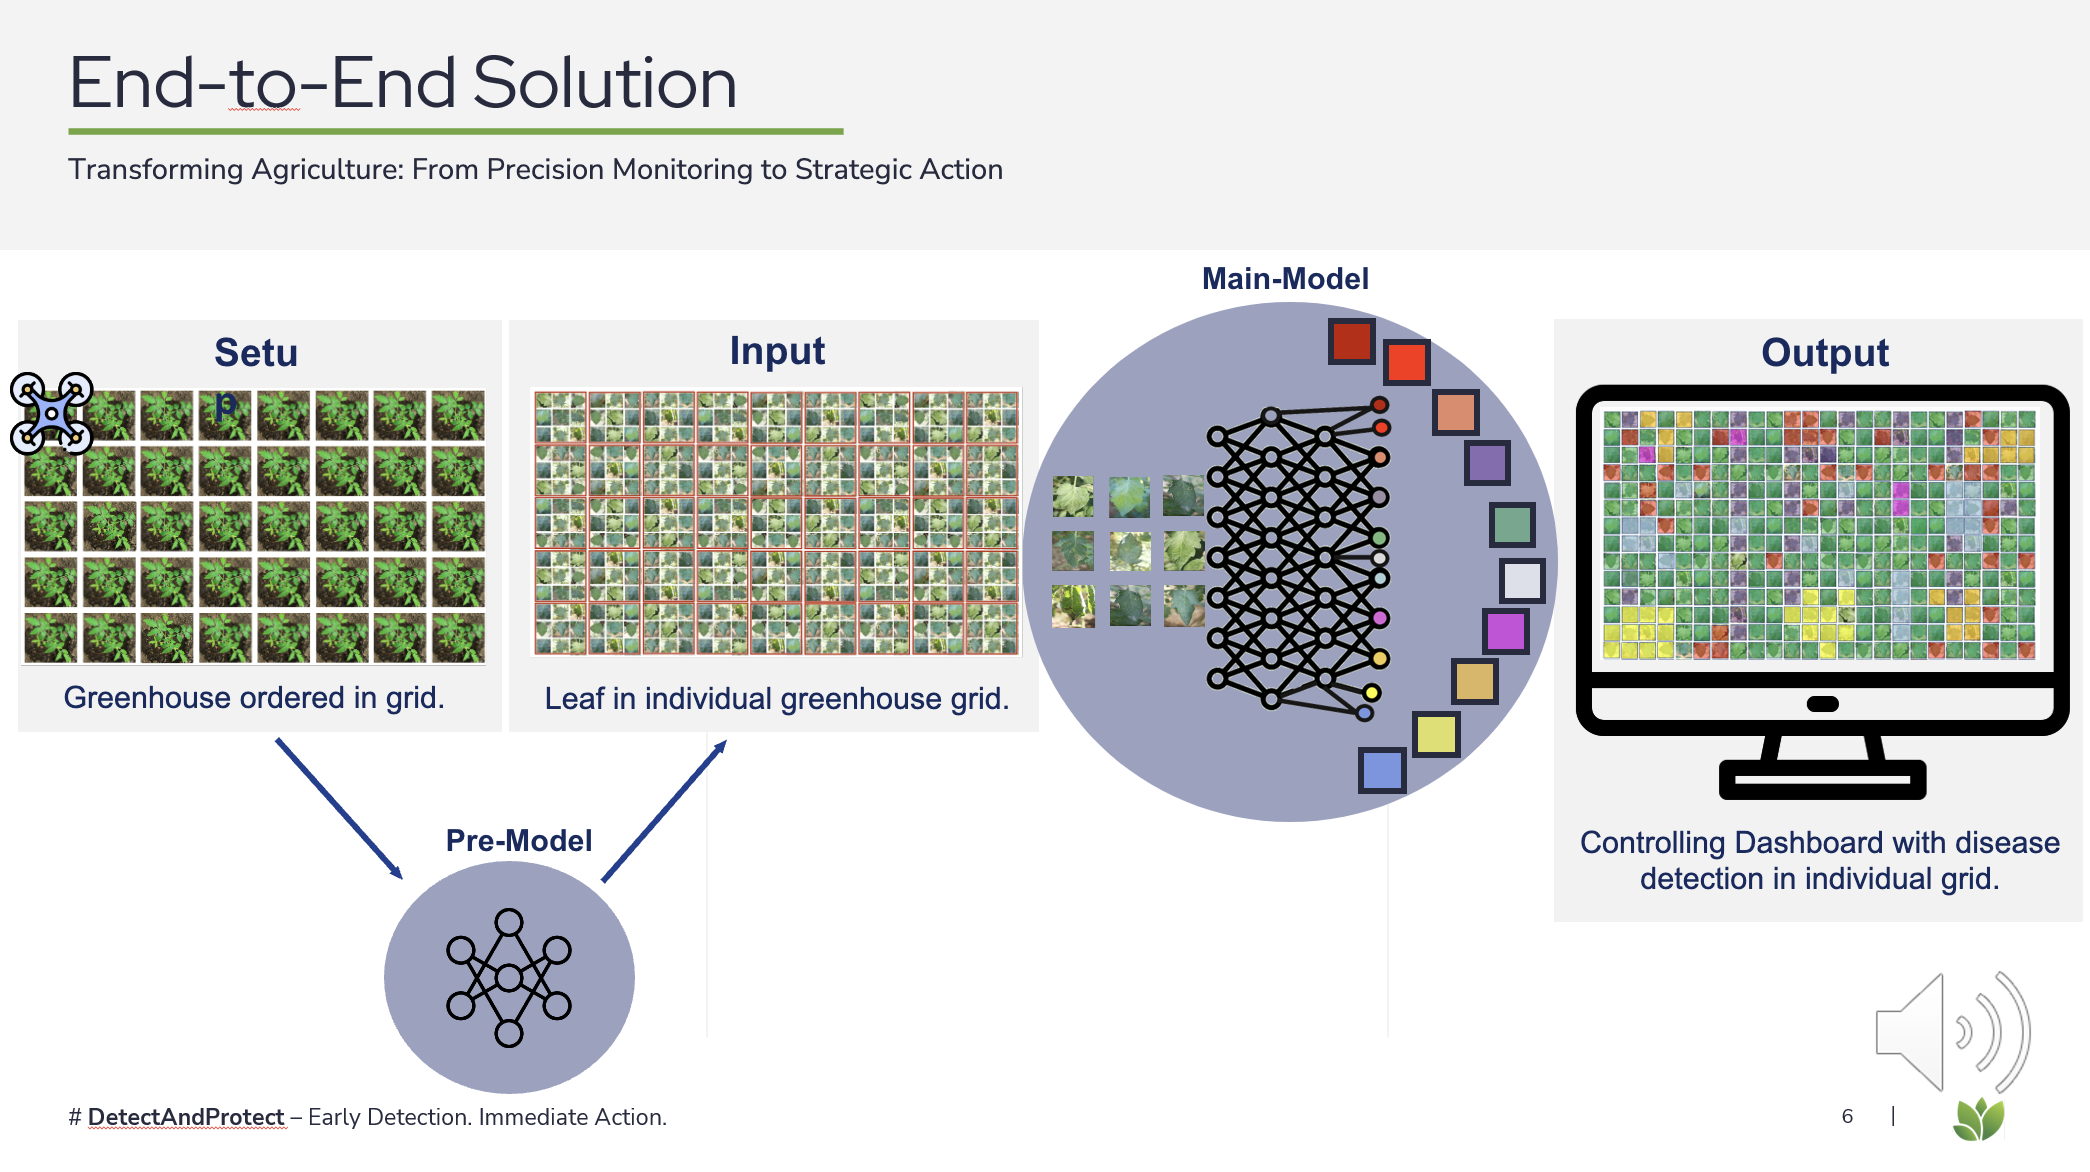

## Imports

Attention, in Tensorflow v2.16.1 there is a bug where epochs are avoided because of some batch issue.
See:
Epoch 3/10
2024-05-13 12:01:51.094548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-13 12:01:51.163083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]

This problem can be avoided by downgrading to tf 2.15.1

(https://github.com/tensorflow/tensorflow/issues/62963)

In [3]:
# TensorFlow 2.16 has weird bug, see below. Therefore I use TF 2.15.1

!pip install tensorflow==2.15.1
!pip install tabulate 

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, accuracy_score
from sklearn.preprocessing import LabelBinarizer


## Prepare Folder Structure & Split Dataset

In [5]:

# Define your data directory
data_dir = 'all_images'

# Define directories for train, validation, and test sets
train_dir = 'baseline/train'
val_dir = 'baseline/val'
test_dir = 'baseline/test'

# Define the ratio for splitting (e.g., 80% train, 10% validation, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Ensure target directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each class folder
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    
    # Skip any non-directory items
    if not os.path.isdir(class_path):
        continue
    
    # List all images in the class folder
    images = os.listdir(class_path)
    
    # Shuffle the images randomly
    random.shuffle(images)
    
    # Calculate split indices
    num_images = len(images)
    train_split = int(num_images * train_ratio)
    val_split = int(num_images * (train_ratio + val_ratio))
    
    # Split the images into train, validation, and test sets
    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]
    
    # Move images to the respective directories
    for image in train_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(train_dir, class_folder, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
    
    for image in val_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(val_dir, class_folder, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
    
    for image in test_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(test_dir, class_folder, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Data split into train, validation, and test sets.")


Data split into train, validation, and test sets.


#### Rescale Images and create Batch Flows

In [6]:
# Define directories for train, validation, and test sets
train_dir = 'baseline/train'
val_dir = 'baseline/val'
test_dir = 'baseline/test'

# Define image dimensions and batch size
img_height = 64
img_width = 64
batch_size = 32

# Create ImageDataGenerator for normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 20371 images belonging to 11 classes.
Found 4055 images belonging to 11 classes.
Found 4026 images belonging to 11 classes.


## Data Prep

### Create Data Arrays from Generators:

In [7]:
X_train = []
y_train = []

for i in range(0, train_generator.samples // batch_size + 1):
    X_train.append(train_generator.__getitem__(i)[0])
    y_train.append(train_generator.__getitem__(i)[1])

X_train = np.concatenate(X_train)
y_train_vec = np.concatenate(y_train)
y_train = np.argmax(y_train_vec, axis=1)

In [8]:
X_val = []
y_val = []

for i in range(0, val_generator.samples // batch_size + 1):
    X_val.append(val_generator.__getitem__(i)[0])
    y_val.append(val_generator.__getitem__(i)[1])

X_val = np.concatenate(X_val)
y_val_vec = np.concatenate(y_val)
y_val = np.argmax(y_val_vec, axis=1)

In [9]:
X_test = []
y_test = []

for i in range(0, test_generator.samples // batch_size + 1):
    X_test.append(test_generator.__getitem__(i)[0])
    y_test.append(test_generator.__getitem__(i)[1])

X_test = np.concatenate(X_test)
y_test_vec = np.concatenate(y_test)
y_test = np.argmax(y_test_vec, axis=1)

### Display Metrics Functions

In [10]:
def view_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(14, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='upper left')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper left')
  plt.title('Training and Validation Loss')
  plt.show()


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score

def calc_metrics(model):
  predictions = model.predict(X_test)
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = np.argmax(y_test_vec, axis=1)

  # Confusion Matrix
  conf_matrix = confusion_matrix(true_classes, predicted_classes)
  print("Confusion Matrix:\n", conf_matrix)

  # Classification Report
  class_report = classification_report(true_classes, predicted_classes)
  print("Classification Report:\n", class_report)

  # ROC AUC Score (multi-class version)
  y_test_binarized = to_categorical(true_classes)
  roc_auc = roc_auc_score(y_test_binarized, predictions, multi_class='ovr')
  print("ROC AUC Score:", roc_auc)

  # Calculating balanced accuracy
  bal_acc = balanced_accuracy_score(true_classes, predicted_classes)
  print("Balanced Accuracy:", bal_acc)

  return roc_auc, bal_acc

# Build "Baseline" CNN Model without pre-training

With this baseline model we have something good to compare later transfer learning models with. We choose a **basic Convolutional Neural Network (CNN)** architecture for it:

In [12]:
model_baseline = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(11, activation='softmax') 
])

# Compile the model
model_baseline.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time = time.time()

# Train the model
history = model_baseline.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Record the end time
end_time = time.time()
# Calculate the training time
training_time = end_time - start_time
print(training_time)

Epoch 1/10
636/636 [==============================] - 93s 145ms/step - loss: 1.3716 - accuracy: 0.5290 - val_loss: 0.7993 - val_accuracy: 0.7252
Epoch 2/10
636/636 [==============================] - 96s 151ms/step - loss: 0.7716 - accuracy: 0.7423 - val_loss: 0.6335 - val_accuracy: 0.7927
Epoch 3/10
636/636 [==============================] - 91s 143ms/step - loss: 0.5498 - accuracy: 0.8140 - val_loss: 0.4974 - val_accuracy: 0.8346
Epoch 4/10
636/636 [==============================] - 93s 146ms/step - loss: 0.3814 - accuracy: 0.8713 - val_loss: 0.3686 - val_accuracy: 0.8852
Epoch 5/10
636/636 [==============================] - 105s 165ms/step - loss: 0.2503 - accuracy: 0.9171 - val_loss: 0.3262 - val_accuracy: 0.9023
Epoch 6/10
636/636 [==============================] - 101s 159ms/step - loss: 0.1578 - accuracy: 0.9503 - val_loss: 0.2593 - val_accuracy: 0.9325
Epoch 7/10
636/636 [==============================] - 101s 159ms/step - loss: 0.1129 - accuracy: 0.9639 - val_loss: 0.2411 - val

In [13]:
test_percentages = model_baseline.predict(X_test)

126/126 [==============================] - 5s 38ms/step


In [14]:
test_pred = np.argmax(test_percentages, axis=1)

### View Model Metrics

#### First, per-class metrics and confusion matrix of assigned classes

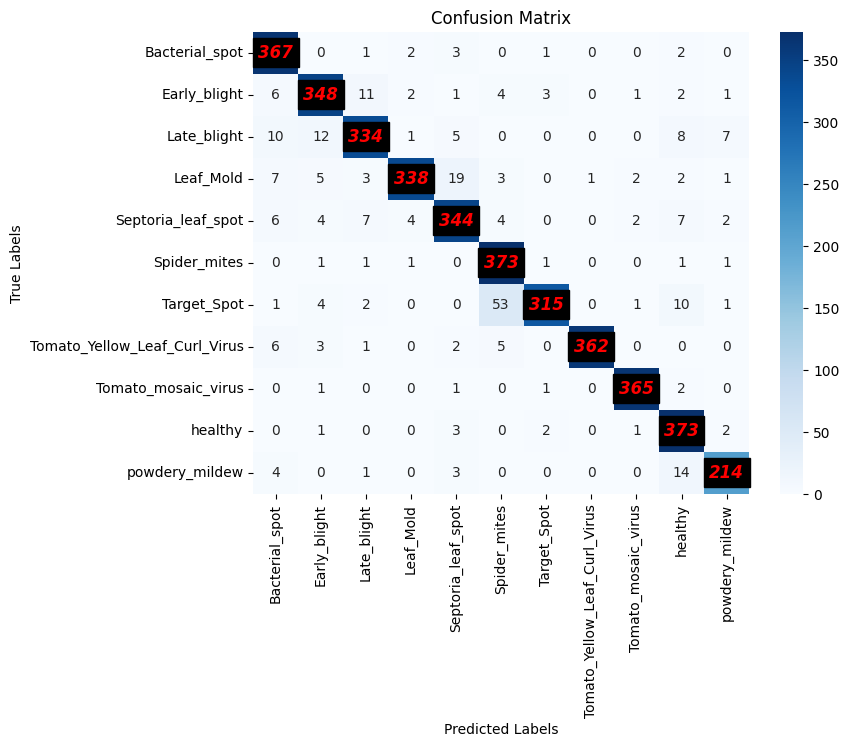

In [16]:
# Get class indices from the test generator
class_indices = test_generator.class_indices

# Reverse the dictionary to get a mapping from class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, test_pred)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())

# Highlight diagonal cells
for i in range(len(class_labels)):
    plt.text(i + 0.5, i + 0.5, conf_matrix[i, i], ha='center', va='center', color='red', fontsize=12, fontweight='bold', fontstyle='italic', bbox=dict(facecolor='black', alpha=1))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# Accuracy is a global metric and doesn't have per-class values like precision, recall, and F1-score ! classification report is per-class metrics

# Generate classification report
report = classification_report(y_test, test_pred, target_names=class_labels, output_dict=True)

# Extract necessary information from the classification report
table_data = []
for class_label, metrics in report.items():
    if class_label in class_labels:
        precision = round(metrics['precision'], 4)
        recall = round(metrics['recall'], 4)
        f1_score = round(metrics['f1-score'], 4)
        table_data.append([class_label, precision, recall, f1_score])

# Print classification report in tabular form without the "support" column
print("Classification Report:")
print(tabulate(table_data, headers=['Class', 'Precision', 'Recall', 'F1 Score']))


Classification Report:
  Class    Precision    Recall    F1 Score
-------  -----------  --------  ----------
      0       0.9017    0.9761      0.9374
      1       0.9182    0.9182      0.9182
      2       0.9252    0.8859      0.9051
      3       0.9713    0.8871      0.9273
      4       0.9029    0.9053      0.9041
      5       0.8439    0.9842      0.9086
      6       0.9752    0.814       0.8873
      7       0.9972    0.9551      0.9757
      8       0.9812    0.9865      0.9838
      9       0.886     0.9764      0.929
     10       0.9345    0.9068      0.9204


#### Secondly, overall model metrics for comparison with other models

In [18]:
accuracy = round(accuracy_score(y_test, test_pred), 4)

# Define a function to calculate macro average
def calculate_macro_average(report):
    macro_avg_precision = round(report['macro avg']['precision'], 4)
    macro_avg_recall = round(report['macro avg']['recall'], 4)
    macro_avg_f1 = round(report['macro avg']['f1-score'], 4) 
    return macro_avg_precision, macro_avg_recall, macro_avg_f1

# Calculate macro average
macro_avg_precision, macro_avg_recall, macro_avg_f1 = calculate_macro_average(report)

# Model-related information
model_name = "Baseline"
trainable_parameters = model_baseline.count_params() 

# Prepare table data
table_data = [
    [model_name, accuracy, precision, f1_score, recall, macro_avg_precision, trainable_parameters, training_time]
]

# Print the table
print("Overall Model Performance:")
print(tabulate(table_data, headers=['Model Name', 'Accuracy', 'Precision', 'F1', 'Recall', 'Macro Average', 'Trainable Parameters', 'Training Time (s)']))


Overall Model Performance:
Model Name      Accuracy    Precision      F1    Recall    Macro Average    Trainable Parameters    Training Time (s)
------------  ----------  -----------  ------  --------  ---------------  ----------------------  -------------------
Baseline          0.9272       0.9345  0.9204    0.9068           0.9307                 3484235              979.699


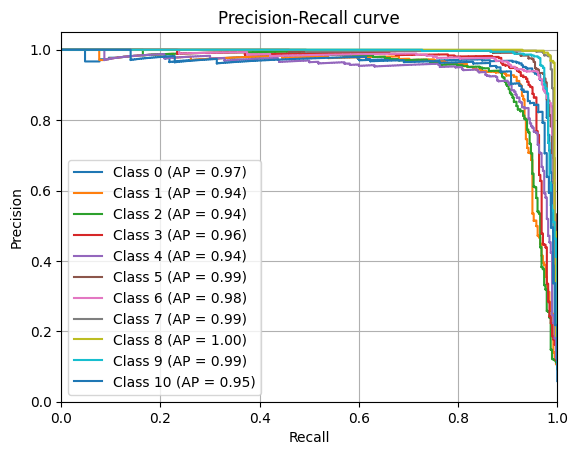

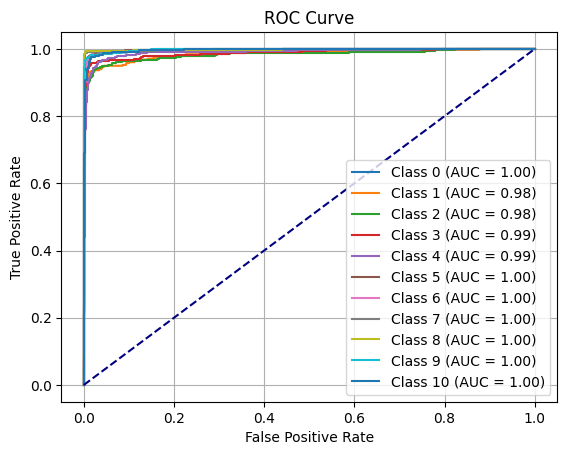

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

num_classes = 11

precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):  # 'num_classes' is the number of classes
    precision[i], recall[i], _ = precision_recall_curve(y_test_vec[:, i], test_percentages[:, i])
    average_precision[i] = average_precision_score(y_test_vec[:, i], test_percentages[:, i])

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_vec[:, i], test_percentages[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot Precision-Recall curve for each class
plt.figure()
for i in range(num_classes):
    plt.step(recall[i], precision[i], where='post', label='Class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.grid()

# Plot ROC curve for each class
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()

plt.show()

In [20]:
model_baseline_metrics = calc_metrics(model_baseline)

126/126 [==============================] - 5s 36ms/step
Confusion Matrix:
 [[367   0   1   2   3   0   1   0   0   2   0]
 [  6 348  11   2   1   4   3   0   1   2   1]
 [ 10  12 334   1   5   0   0   0   0   8   7]
 [  7   5   3 338  19   3   0   1   2   2   1]
 [  6   4   7   4 344   4   0   0   2   7   2]
 [  0   1   1   1   0 373   1   0   0   1   1]
 [  1   4   2   0   0  53 315   0   1  10   1]
 [  6   3   1   0   2   5   0 362   0   0   0]
 [  0   1   0   0   1   0   1   0 365   2   0]
 [  0   1   0   0   3   0   2   0   1 373   2]
 [  4   0   1   0   3   0   0   0   0  14 214]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       376
           1       0.92      0.92      0.92       379
           2       0.93      0.89      0.91       377
           3       0.97      0.89      0.93       381
           4       0.90      0.91      0.90       380
           5       0.84      0.98      0.91       379
    

# Finetuning pretrained Models

### Infrastructure
 Functions to create all transfer models:

In [21]:
from tensorflow import keras

input_shape = (64, 64, 3)
epochs = 10

In [22]:
def load_model(model_name, input_shape):
    if model_name == 'VGG16':
        base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNet':
        base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetB0':
        base_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    return base_model


In [23]:
def set_non_trainable(model):
    model.trainable = False
    model.summary()
    return model


In [24]:
def add_custom_layers(base_model):
    model = keras.Sequential([
        base_model,
        keras.layers.Flatten(),
        keras.layers.Dense(500, activation='relu'),
        keras.layers.Dense(11, activation='softmax')
    ])
    return model


## Transfer Learning Models:

Transfer learning models **leverage knowledge gained from pre-training on large datasets** (like ImageNet in our case) to improve performance on the specific task at hand. They serve as strong baselines and often outperform models trained from scratch, especially when training data is limited. We are going to try our task with these transfer learning models:

* **VGG16:** A convolutional neural network known for its simple architecture, consisting of multiple convolutional layers followed by max-pooling and fully connected layers. Pre-trained on ImageNet, it offers a good balance between performance and complexity.
  
* **ResNet50:** A deeper network that addresses the vanishing gradient problem using residual connections. It enables the training of much deeper models, leading to improved performance on various tasks.
  
* **MobileNet:** Designed for mobile and embedded vision applications, MobileNet prioritizes efficiency by using depthwise separable convolutions. This reduces computational cost and model size while maintaining competitive accuracy.
  
* **EfficientNet:** A family of models that scales efficiently across depth, width, and resolution. They achieve state-of-the-art accuracy with significantly reduced parameters and FLOPS compared to other models.


### VGG16

In [25]:
vgg16_base = load_model('VGG16', input_shape)
vgg16_base = set_non_trainable(vgg16_base)
vgg16_transfer = add_custom_layers(vgg16_base)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [26]:
vgg16_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               1024500   
                                                                 
 dense_3 (Dense)             (None, 11)                5511      
                                                                 
Total params: 15744699 (60.06 MB)
Trainable params: 1030011 (3.93 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [27]:
start_time = time.time()

vgg16_transfer_history = vgg16_transfer.fit(x=X_train, y=y_train_vec, validation_data=(X_val, y_val_vec), epochs=10) 

end_time = time.time()

vgg16_training_time = end_time - start_time

Epoch 1/10
637/637 [==============================] - 279s 437ms/step - loss: 1.0907 - accuracy: 0.6359 - val_loss: 0.7727 - val_accuracy: 0.7398
Epoch 2/10
637/637 [==============================] - 246s 386ms/step - loss: 0.7258 - accuracy: 0.7541 - val_loss: 0.5934 - val_accuracy: 0.8017
Epoch 3/10
637/637 [==============================] - 249s 391ms/step - loss: 0.5930 - accuracy: 0.7978 - val_loss: 0.5533 - val_accuracy: 0.8128
Epoch 4/10
637/637 [==============================] - 255s 401ms/step - loss: 0.4878 - accuracy: 0.8321 - val_loss: 0.4829 - val_accuracy: 0.8311
Epoch 5/10
637/637 [==============================] - 244s 384ms/step - loss: 0.4120 - accuracy: 0.8572 - val_loss: 0.4336 - val_accuracy: 0.8523
Epoch 6/10
637/637 [==============================] - 244s 383ms/step - loss: 0.3488 - accuracy: 0.8799 - val_loss: 0.3239 - val_accuracy: 0.8954
Epoch 7/10
637/637 [==============================] - 244s 383ms/step - loss: 0.2868 - accuracy: 0.9029 - val_loss: 0.2745 -

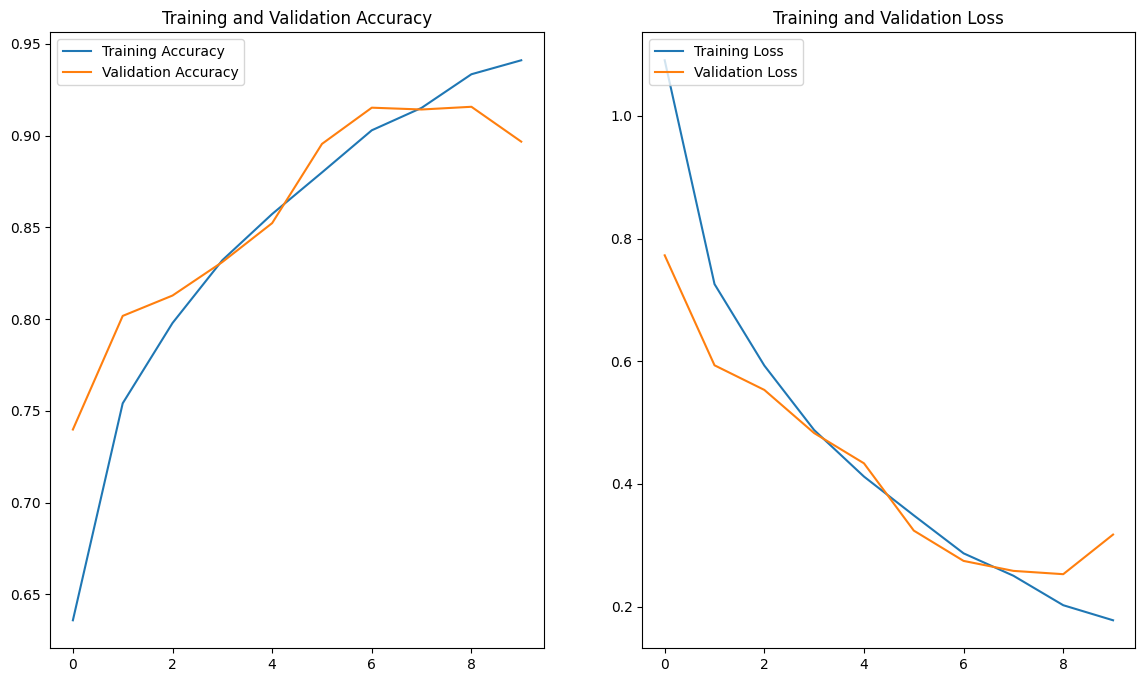

In [28]:
view_history(vgg16_transfer_history)

In [29]:
vgg16_transfer_metrics = calc_metrics(vgg16_transfer)

126/126 [==============================] - 39s 310ms/step
Confusion Matrix:
 [[367   3   0   1   2   0   0   2   0   0   1]
 [  4 361   1   1   3   0   1   2   3   1   2]
 [ 21  29 284  13  15   1   0   3   8   0   3]
 [  4   9   1 352   4   0   0   0  10   1   0]
 [ 11   5   3   9 330   0   1   2  17   1   1]
 [  0  31   0   1   0 298   5  10  33   1   0]
 [  4  26   2   1   5  15 275   6  35  18   0]
 [  5   1   0   0   1   2   0 365   5   0   0]
 [  0   1   0   0   0   0   0   0 369   0   0]
 [  1   0   0   0   0   1   2   0   2 376   0]
 [  3   2   3   0   6   0   0   0   1   1 220]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       376
           1       0.77      0.95      0.85       379
           2       0.97      0.75      0.85       377
           3       0.93      0.92      0.93       381
           4       0.90      0.87      0.88       380
           5       0.94      0.79      0.86       379
  

### ResNet50

In [31]:
resnet_base = load_model('ResNet50', input_shape)
resnet_base = set_non_trainable(resnet_base)
resnet_transfer = add_custom_layers(resnet_base)

resnet_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_transfer.summary()

start_time = time.time()
resnet_transfer_history = resnet_transfer.fit(x=X_train, y=y_train_vec, validation_data=(X_val, y_val_vec), epochs=10) 
end_time = time.time()

resnet_training_time = end_time - start_time

resnet_transfer_metrics = calc_metrics(resnet_transfer)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

### MobileNet

In [32]:
mobilenet_base = load_model('MobileNet', input_shape)
mobilenet_base = set_non_trainable(mobilenet_base)
mobilenet_transfer = add_custom_layers(mobilenet_base)

mobilenet_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_transfer.summary()

start_time = time.time()
mobilenet_transfer_history = mobilenet_transfer.fit(x=X_train, y=y_train_vec, validation_data=(X_val, y_val_vec), epochs=10) 
end_time = time.time()

mobilenet_training_time = end_time - start_time

mobilenet_transfer_metrics = calc_metrics(mobilenet_transfer)

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 32, 32, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 32, 32, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 32, 32, 32) 

### EfficientNetB0

In [33]:
efficientnet_base = load_model('EfficientNetB0', input_shape)
efficientnet_base = set_non_trainable(efficientnet_base)
efficientnet_transfer = add_custom_layers(efficientnet_base)

efficientnet_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
efficientnet_transfer.summary()

start_time = time.time()
efficientnet_transfer_history = efficientnet_transfer.fit(x=X_train, y=y_train_vec, validation_data=(X_val, y_val_vec), epochs=10) 
end_time = time.time()

efficientnet_training_time = end_time - start_time

efficientnet_transfer_metrics = calc_metrics(efficientnet_transfer)

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 64, 64, 3)            0         ['input_4[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 64, 64, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 64, 64, 3)            0         ['normalization[0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Comparison of all Models

In [46]:
model_baseline_metrics = list(model_baseline_metrics) + [training_time]
vgg16_transfer_metrics = list(vgg16_transfer_metrics) + [vgg16_training_time]
resnet_transfer_metrics = list(resnet_transfer_metrics) + [resnet_training_time]
mobilenet_transfer_metrics = list(mobilenet_transfer_metrics) + [mobilenet_training_time]
efficientnet_transfer_metrics = list(efficientnet_transfer_metrics) + [efficientnet_training_time]

metrics = [model_baseline_metrics[:3], vgg16_transfer_metrics[:3], resnet_transfer_metrics[:3], mobilenet_transfer_metrics[:3], efficientnet_transfer_metrics[:3]]

models = ["Baseline", "VGG16", "ResNet50", "MobileNet", "EfficientNet"]

# Create DataFrame
metrics_df = pd.DataFrame(metrics, columns=['ROC', 'Balanced Accuracy', 'Training Time'], index=models)

# Display DataFrame
metrics_df

,ROC,Balanced Accuracy,Training Time
Baseline,0.993366,0.926872,979.698930
VGG16,0.995949,0.895265,2494.739702
ResNet50,0.901305,0.545621,1918.283353
MobileNet,0.997036,0.952059,564.024497
EfficientNet,0.499932,0.090909,1063.497017


The table presents a comparison of various deep learning models for a classification task based on three metrics: ROC (Receiver Operating Characteristic), Balanced Accuracy, and Training Time.

**Performance Evaluation:**

* **ROC:** MobileNet demonstrates the highest ROC (0.997036), followed closely by VGG16 (0.995949). This indicates that these two models possess the strongest ability to distinguish between classes.

* **Balanced Accuracy:** MobileNet again leads with the highest Balanced Accuracy (0.952059), suggesting superior overall performance across classes, especially in the case of imbalanced data. The Baseline model follows closely with a Balanced Accuracy of (0.926872).

* **Training Time:** MobileNet also boasts the shortest training time (564.02 seconds), making it the most efficient model in terms of computational resources.

**Best Model:**
Based on the combined evaluation of ROC, Balanced Accuracy, and Training Time, **MobileNet emerges as the most effective and efficient model for the given task**. It achieves the best classification performance while requiring significantly less training time compared to other models.